# Amaon Sentiment Analysis

# Imports

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

np.random.seed(1)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import torch

### Dataset Location: https://www.kaggle.com/datasets/miriamodeyianypeter/sentiment-analysis-amazon-product-reviews/data

# Functions

In [33]:
def check_class_imbalance(df):
  y = df.values[:,-1]
  counter = Counter(y)
  for k,v in counter.items():
    per = v/len(y) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))

def sentiment_score(review, tokenizer, model):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits)) +1

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores
def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = SVC()
    
    param_grid = {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    
    return grid_search
def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    param_grid = {
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    model = LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {accuracy:.3f}')
def grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
            
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
            
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Test accuracy for {name}: {accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_pred)
        # Plot the confusion matrix
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Test Accuracy": accuracy,
                "Best Parameters": grid_search.best_params_
        })


    model_performance_df = pd.DataFrame(model_performance)
    print(model_performance_df)

In [34]:
PATH = "/Users/maukanmir/Downloads/amazon.csv"

In [35]:
eda_df = pd.read_csv(PATH)
eda_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30841,US,44834233,R366C7ARIWLN7R,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3720,3875,N,Y,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,2014-10-03,1
30842,US,13376158,R35PL0AOCUXLU9,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,2716,2849,N,Y,Great Value for $139,I'm writing this review with the benefit of be...,2014-10-03,1
30843,US,40485963,R18ZJVY86AUFII,B00KC6XV58,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1525,1629,N,Y,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",2014-10-03,1
30844,US,33485035,R36QVLQXMCZRSJ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,143,163,N,Y,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,2014-10-03,1


# Check for Nulls and Dupes

In [36]:
print(f"Number of Null values: {eda_df.isna().sum()}")
print(f"Number of Dupe values: {eda_df.duplicated().sum()}")

Number of Null values: marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64
Number of Dupe values: 0


In [37]:
eda_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30841,US,44834233,R366C7ARIWLN7R,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3720,3875,N,Y,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,2014-10-03,1
30842,US,13376158,R35PL0AOCUXLU9,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,2716,2849,N,Y,Great Value for $139,I'm writing this review with the benefit of be...,2014-10-03,1
30843,US,40485963,R18ZJVY86AUFII,B00KC6XV58,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1525,1629,N,Y,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",2014-10-03,1
30844,US,33485035,R36QVLQXMCZRSJ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,143,163,N,Y,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,2014-10-03,1


In [38]:
columns_of_interest = ["marketplace", "product_title", "product_category", "vine", "verified_purchase", "review_date"]

for col in columns_of_interest:
  unique_values = eda_df[col].unique()
  print(unique_values)
  print(len(unique_values))

['US']
1
['Fire HD 7, 7" HD Display, Wi-Fi, 8 GB']
1
['PC']
1
['N']
1
['Y' 'N']
2
['2015-08-31' '2015-08-30' '2015-08-29' '2015-08-28' '2015-08-27'
 '2015-08-26' '2015-08-25' '2015-08-24' '2015-08-23' '2015-08-22'
 '2015-08-21' '2015-08-20' '2015-08-19' '2015-08-18' '2015-08-17'
 '2015-08-16' '2015-08-15' '2015-08-14' '2015-08-13' '2015-08-12'
 '2015-08-11' '2015-08-10' '2015-08-09' '2015-08-08' '2015-08-07'
 '2015-08-06' '2015-08-05' '2015-08-04' '2015-08-03' '2015-08-02'
 '2015-08-01' '2015-07-31' '2015-07-30' '2015-07-29' '2015-07-28'
 '2015-07-27' '2015-07-26' '2015-07-25' '2015-07-24' '2015-07-23'
 '2015-07-22' '2015-07-21' '2015-07-20' '2015-07-19' '2015-07-18'
 '2015-07-17' '2015-07-16' '2015-07-15' '2015-07-14' '2015-07-13'
 '2015-07-12' '2015-07-11' '2015-07-10' '2015-07-09' '2015-07-08'
 '2015-07-07' '2015-07-06' '2015-07-05' '2015-07-04' '2015-07-03'
 '2015-07-02' '2015-07-01' '2015-06-30' '2015-06-29' '2015-06-28'
 '2015-06-27' '2015-06-26' '2015-06-25' '2015-06-24' '2015-0

# Drop redundant columns

In [39]:
eda_df.drop(["marketplace", "product_title", "product_category", "vine", "customer_id", "review_id", "product_parent", "product_id", "review_date"], axis=1, inplace=True)

# Separate into another df

In [40]:
df = eda_df.copy()

In [41]:
df["verified_purchase"] = df["verified_purchase"].apply(lambda x: 1 if x == 'Y' else 0 )

In [42]:
df

,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,sentiment
0,5,0,0,1,Five Stars,Great love it,1
1,3,0,0,0,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,0
2,5,0,0,1,Well thought out device,Excellent unit. The versatility of this table...,1
3,4,0,0,0,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,1
4,5,0,0,1,Five Stars,All Amazon products continue to meet my expect...,1
...,...,...,...,...,...,...,...
30841,5,3720,3875,1,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,1
30842,5,2716,2849,1,Great Value for $139,I'm writing this review with the benefit of be...,1
30843,5,1525,1629,1,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",1
30844,4,143,163,1,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,1


# Check for class imbalance

In [43]:
check_class_imbalance(df)

Class=1, Count=25767, Percentage=83.534%
Class=0, Count=5079, Percentage=16.466%


# Visuals

<AxesSubplot:xlabel='star_rating', ylabel='total_votes'>

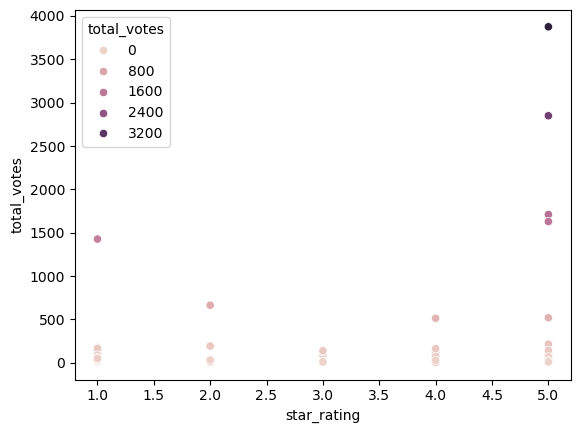

In [47]:
sns.scatterplot(data=df, x="star_rating",y='total_votes',hue="total_votes")